In [93]:
#libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb   #machine learning model based on random forest algorithm
from sklearn.metrics import mean_squared_error
#from sklearn.datasets import load_boston    #has tbeen removed
from sklearn.model_selection import train_test_split
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

### Import data in .csv format and change Format of Datetime

In [70]:
df = pd.read_csv('prc_Food_Germany_sorted.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

### First Training without Ukraine Confilct

In [71]:
df_cleaned = df.loc[df.index < '2021-11']

### Plot Data

<function matplotlib.pyplot.show(close=None, block=None)>

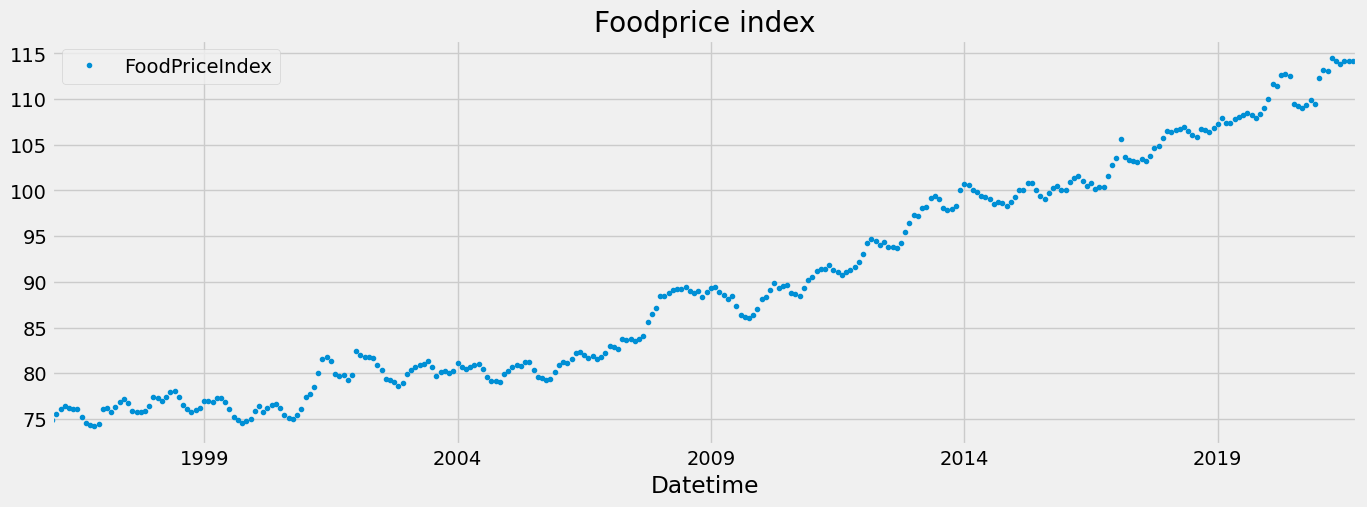

In [72]:
df_cleaned.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Foodprice index')
plt.show

## Train/Test Split

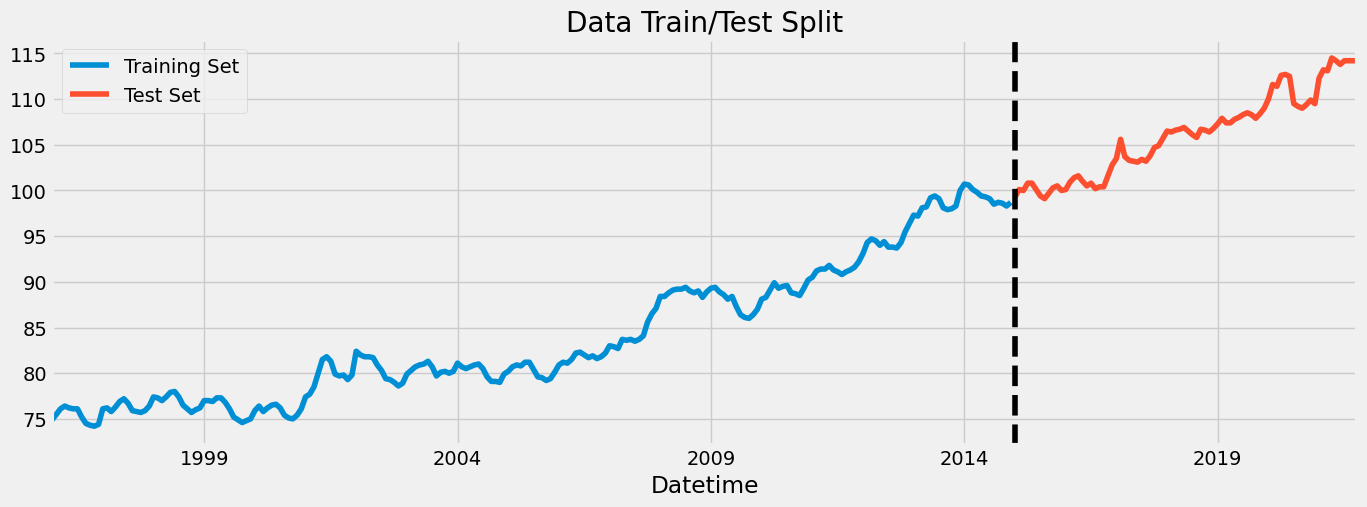

In [73]:
train = df_cleaned.loc[df_cleaned.index < '2015-01']
test = df_cleaned.loc[df_cleaned.index >= '2015-01']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2015-01',color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()
           

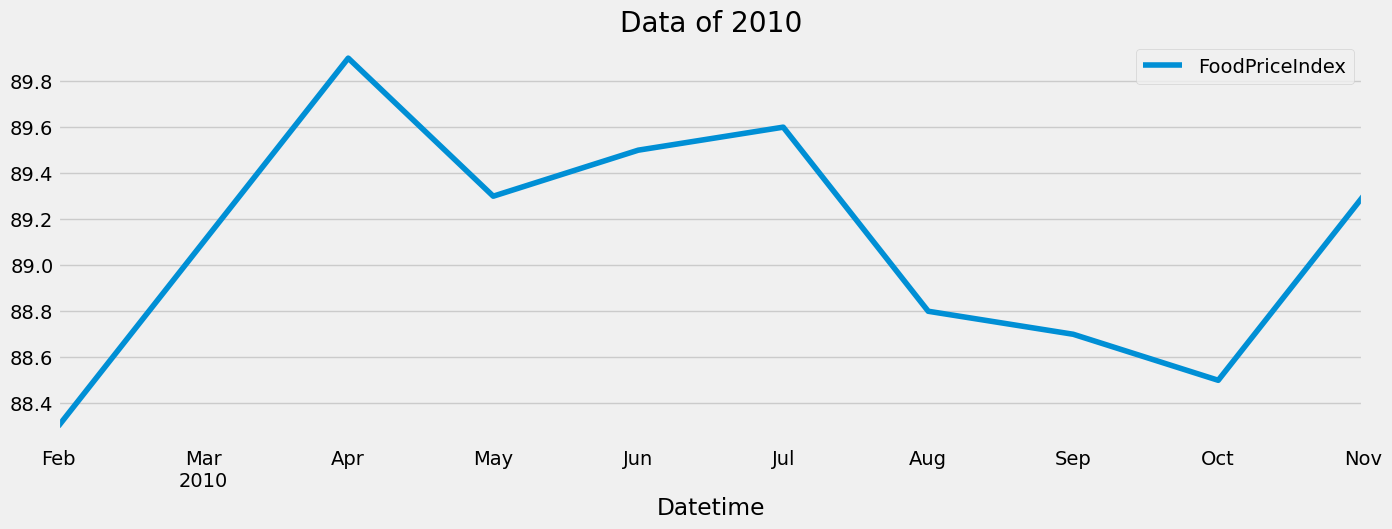

In [74]:
df_cleaned.loc[(df_cleaned.index > '2010-01') & (df_cleaned.index < '2010-12')].plot(figsize=(15, 5), title='Data of 2010')
plt.show()

### Feature Creation

In [75]:
def create_features(df_cleaned):
    """
    Create time series features based on time series index.

    """
    df_cleaned = df_cleaned.copy()
    df_cleaned['Month'] = df_cleaned.index.month
    df_cleaned['Year'] = df_cleaned.index.year
    df_cleaned['Quarter'] = df_cleaned.index.quarter
    #df_cleaned['MonthOfYear'] = df_cleaned.index.     gibts scheinbar nicht
    return df_cleaned

df_cleaned = create_features(df_cleaned)

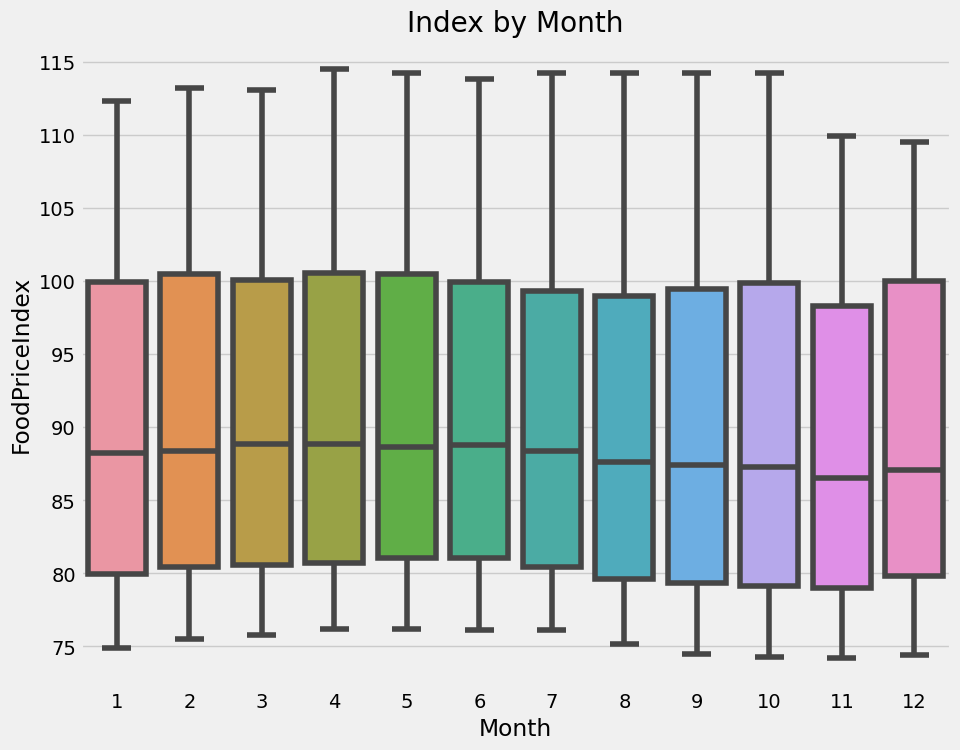

In [76]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_cleaned, x='Month', y='FoodPriceIndex')      #hier kann n boxplot erstellen der über alle tage jeweils di Stsunden plottet. Oder auch ander Features, die man oben definiert hat
ax.set_title('Index by Month')
plt.show()

### Create our model

In [77]:
train = create_features(train)
test = create_features(test)

FEATURES = ['Month','Year','Quarter']
TARGET = 'FoodPriceIndex'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

#### different approach for learner, taken from: https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

In [122]:
dmatrix = xgb.DMatrix(data=X_train, label=y_train)
params = { 'objective':'reg:squarederror',
          'max_depth':6,
          'colsample_bylevel':0.5,
          'learning_rate':0.01,
          'random_state':20}
cv_results = xgb.cv(dtrain=dmatrix, params=params,
                    nfold=10, metrics={'rmse'}, as_pandas=True, seed=20,
                    num_boost_round=1000)
print('RMSE: %.2f' % cv_results['test-rmse-mean'].min())


RMSE: 0.77


### actually do the training

In [90]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',                        #xgb basiert auf random forest, dauert ca. 23 sekunden ohne gpu, easy schnmeasy
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,                                                       #wenn validation rmse wieder wächst hat man wohl overfitting
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=20)

[14:52:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:83.03070	validation_1-rmse:104.77929
[20]	validation_0-rmse:68.06535	validation_1-rmse:88.38458
[40]	validation_0-rmse:55.80794	validation_1-rmse:74.96701


[60]	validation_0-rmse:45.76921	validation_1-rmse:63.75030
[80]	validation_0-rmse:37.54608	validation_1-rmse:54.46178
[100]	validation_0-rmse:30.80726	validation_1-rmse:46.56275
[120]	validation_0-rmse:25.28238	validation_1-rmse:40.06345
[140]	validation_0-rmse:20.75324	validation_1-rmse:34.69856
[160]	validation_0-rmse:17.03966	validation_1-rmse:30.17074
[180]	validation_0-rmse:13.99490	validation_1-rmse:26.34023
[200]	validation_0-rmse:11.49925	validation_1-rmse:23.20335
[220]	validation_0-rmse:9.45427	validation_1-rmse:20.60066
[240]	validation_0-rmse:7.77963	validation_1-rmse:18.44840
[260]	validation_0-rmse:6.40869	validation_1-rmse:16.69155
[280]	validation_0-rmse:5.28690	validation_1-rmse:15.23501
[300]	validation_0-rmse:4.37003	validation_1-rmse:14.04839
[320]	validation_0-rmse:3.62211	validation_1-rmse:13.07395
[340]	validation_0-rmse:3.01350	validation_1-rmse:12.26798
[360]	validation_0-rmse:2.51964	validation_1-rmse:11.60237
[380]	validation_0-rmse:2.12140	validation_1-rmse:

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

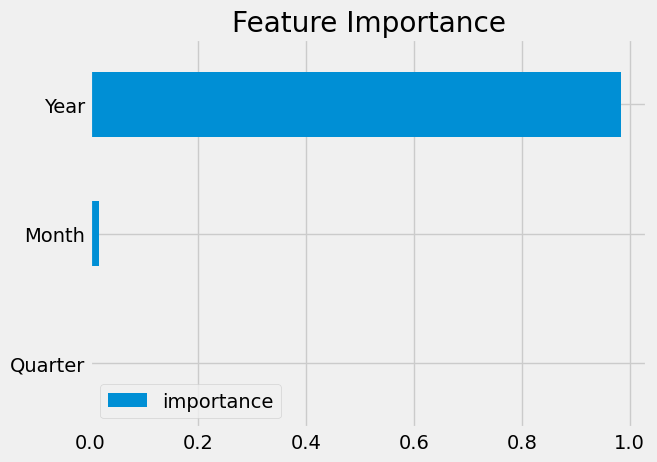

In [79]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

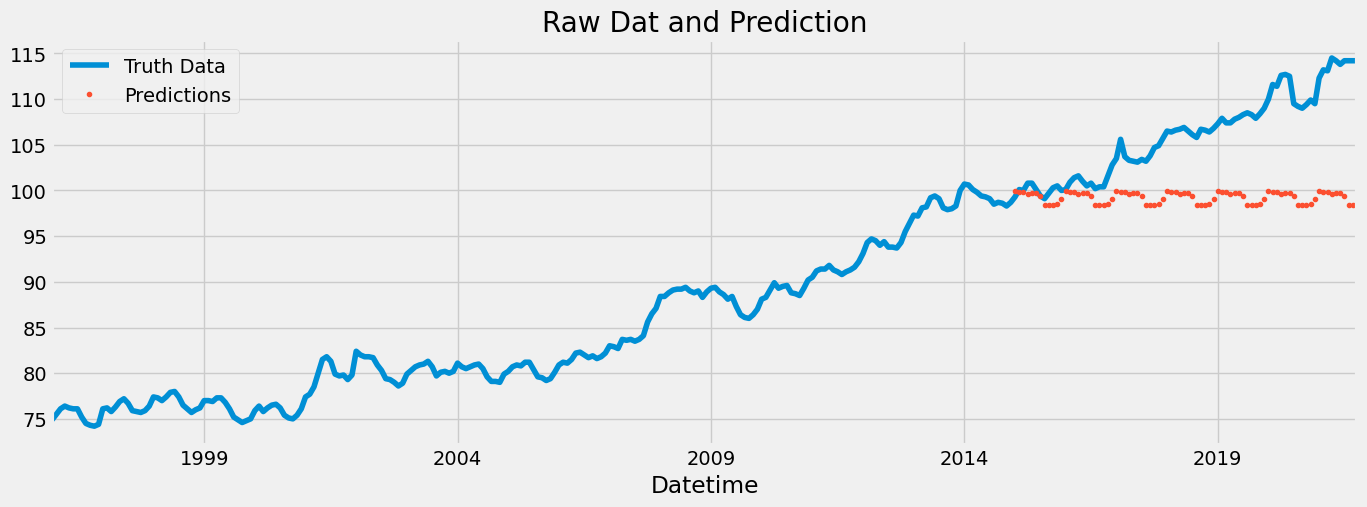

In [80]:
#dieser Block kompiliert irgendwie nur beim ersten mal. also einmal allen output löschen, 
#und dann nochmal alles ausführen
test['prediction'] = reg.predict(X_test)
df_cleaned = df_cleaned.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df_cleaned[['FoodPriceIndex']].plot(figsize=(15, 5))
df_cleaned['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

### Plot cv results


In [118]:
num_boost_rounds = len(cv_results)

# Create an empty array to store the predictions
all_predictions = np.zeros((num_boost_rounds, dmatrix.num_row()))

# Now, for each fold and each boosting round, obtain predictions
#for i in range(num_boost_rounds):
    # Train the XGBoost model on the entire training data for this boosting round
bst = xgb.train(
    params,
    dtrain=dmatrix  # +1 because the index starts from 0
    )

    # Use the trained model to make predictions on the test data for this boosting round
predictions = bst.predict(dmatrix)

    # Store the predictions in the array
#all_predictions[i, :] = predictions

In [121]:
predictions

(228,)